In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from missforest import MissForest
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import chi2, SelectPercentile, f_classif, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from lazypredict.Supervised import LazyClassifier

/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data Preprocessing

In [2]:
data = pd.read_csv('../Data/MedIntel_BC_Vault42/JUNO_Protected_BC_Clinical.tsv', sep="\t")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study ID                        2509 non-null   object 
 1   Patient ID                      2509 non-null   object 
 2   Sample ID                       2509 non-null   object 
 3   Age at Diagnosis                2498 non-null   float64
 4   Type of Breast Surgery          1955 non-null   object 
 5   Cancer Type                     2509 non-null   object 
 6   Cancer Type Detailed            2509 non-null   object 
 7   Cellularity                     1917 non-null   object 
 8   Chemotherapy                    1980 non-null   object 
 9   Pam50 + Claudin-low subtype     1980 non-null   object 
 10  Cohort                          2498 non-null   float64
 11  ER status measured by IHC       2426 non-null   object 
 12  ER Status                       24

### Drop

In [4]:
data.drop(['Study ID', 'Sample ID'], axis=1, inplace=True)
data.dropna(subset=['Tumor Stage'], inplace=True)
data.dropna(subset=['Relapse Free Status'], inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1767 entries, 0 to 2505
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      1767 non-null   object 
 1   Age at Diagnosis                1767 non-null   float64
 2   Type of Breast Surgery          1447 non-null   object 
 3   Cancer Type                     1767 non-null   object 
 4   Cancer Type Detailed            1767 non-null   object 
 5   Cellularity                     1409 non-null   object 
 6   Chemotherapy                    1465 non-null   object 
 7   Pam50 + Claudin-low subtype     1465 non-null   object 
 8   Cohort                          1767 non-null   float64
 9   ER status measured by IHC       1713 non-null   object 
 10  ER Status                       1739 non-null   object 
 11  Neoplasm Histologic Grade       1701 non-null   float64
 12  HER2 status measured by SNP6    1465 no

### Check null values

In [6]:
data['Tumor Stage'].isnull().sum()

0

In [7]:
data['Relapse Free Status'].isnull().sum()

0

In [8]:
data[data[['Tumor Stage', 'Relapse Free Status']].isna().all(axis=1)]

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status


### Unique values

In [9]:
# imblanced data
data['Tumor Stage'].value_counts()

Tumor Stage
2.00    976
1.00    624
3.00    143
0.00     13
4.00     11
Name: count, dtype: int64

In [10]:
data['Relapse Free Status'].value_counts()

Relapse Free Status
0:Not Recurred    1039
1:Recurred         728
Name: count, dtype: int64

In [11]:
data["Tumor Stage"].unique()

array([2., 1., 4., 3., 0.])

### Replace

In [12]:
data['ER status measured by IHC'].replace({'Positve':'Positive'}, inplace=True)

In [13]:
data['Tumor Stage'].replace({0.0:0, 1.0:1, 2.0:2, 3.0:3, 4.0:4}, inplace=True)

In [14]:
# Relapse Free Status
# 0:Not Recurred
# 1:Recurred

data['Relapse Free Status'].replace({'0:Not Recurred':0, '1:Recurred':1}, inplace=True)

In [15]:
# Overall Survival Status
# 1:DECEASED    822
# 0:LIVING      643

data['Overall Survival Status'].replace({'1:DECEASED':1, '0:LIVING':0}, inplace=True)

In [16]:
data[['Relapse Free Status', 'Tumor Stage', 'Overall Survival Status']].head(20)

,Relapse Free Status,Tumor Stage,Overall Survival Status
0,0,2.00,0.00
1,0,1.00,0.00
2,1,2.00,1.00
3,0,2.00,0.00
4,1,2.00,1.00
5,1,4.00,1.00
6,0,2.00,0.00
7,1,3.00,1.00
8,0,2.00,1.00
9,1,2.00,NaN


### Features type

In [17]:
Cellularity_1 = ['Low', 'Moderate', 'High', np.nan]
Chemotherapy_1 = ['NO', 'YES', np.nan]
ER_status_measured_by_IHC_1 = ['Negative', 'Positive', np.nan]
ER_Status_1 = ['Negative', 'Positive', np.nan]
Neoplasm_Histologic_Grade_1 = [1, 2, 3, np.nan]
HER2_Status_1 = ['Negative', 'Positive', np.nan]
Hormone_Therapy_1 = ['NO', 'YES', np.nan]
Inferred_Menopausal_State_1 = ['Pre', 'Post', np.nan]
Integrative_Cluster_1 = ['1', '2', '3', '4ER-', '4ER+', '5', '6', '7', '8', '9', '10', np.nan]
Primary_Tumor_Laterality_1 = ['Left', 'Right', np.nan]
Overall_Survival_Status_1 = [0, 1, np.nan]
PR_Status_1 = ['Negative', 'Positive', np.nan]
Radio_Therapy_1 = ['NO', 'YES', np.nan]
Relapse_Free_Status_1 = [0, 1]
Tumor_Stage_1 = [0, 1, 2, 3, 4]

In [18]:
numerical_feature = ['Age at Diagnosis',
                     'Lymph nodes examined positive', 
                     'Mutation Count', 
                     'Nottingham prognostic index', 
                     'Overall Survival (Months)',
                     'Relapse Free Status (Months)',
                     'Number of Samples Per Patient', 
                     'TMB (nonsynonymous)', 
                     'Tumor Size',
                    ]

ordinal_feature = ['Cellularity', 
                   'Chemotherapy', 
                   'ER status measured by IHC', 
                   'ER Status', 
                   'Neoplasm Histologic Grade', 
                   'HER2 Status', 
                   'Hormone Therapy', 
                   'Inferred Menopausal State', 
                   'Primary Tumor Laterality', 
                   'Overall Survival Status', 
                   'PR Status', 
                   'Radio Therapy',
                   'Integrative Cluster'
                   ]

nominal_feature = ['Cancer Type', 
                   'Type of Breast Surgery', 
                   'Cancer Type Detailed', 
                   'Pam50 + Claudin-low subtype', 
                   'Cohort', 
                   'HER2 status measured by SNP6', 
                   'Tumor Other Histologic Subtype', 
                   'Oncotree Code', 
                   'Sample Type', 
                   'Sex', 
                   '3-Gene classifier subtype', 
                   "Patient's Vital Status"
                   ]

In [19]:
len(numerical_feature) + len(ordinal_feature) + len(nominal_feature)

34

In [20]:
data['Integrative Cluster'].head(5)

0    4ER+
1    4ER+
2       3
3       9
4       9
Name: Integrative Cluster, dtype: object

### Split by column

In [21]:
x = data.drop(['Patient ID', 'Tumor Stage', 'Relapse Free Status'], axis=1)
y_stage = data['Tumor Stage']
y_relapse = data['Relapse Free Status']

## Pipeline

In [22]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[
            Cellularity_1,
            Chemotherapy_1,
            ER_status_measured_by_IHC_1,
            ER_Status_1,
            Neoplasm_Histologic_Grade_1,
            HER2_Status_1,
            Hormone_Therapy_1,
            Inferred_Menopausal_State_1,
            Integrative_Cluster_1,
            Primary_Tumor_Laterality_1,
            Overall_Survival_Status_1,
            PR_Status_1,
            Radio_Therapy_1
            ]))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])


In [23]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical_features', numerical_transformer, numerical_feature),
    ('ordinal_feature', ordinal_transformer, [
            'Cellularity',
            'Chemotherapy',
            'ER status measured by IHC',
            'ER Status',
            'Neoplasm Histologic Grade',
            'HER2 Status',
            'Hormone Therapy',
            'Inferred Menopausal State',
            'Integrative Cluster',
            'Primary Tumor Laterality',
            'Overall Survival Status',
            'PR Status',
            'Radio Therapy'
            ]
    ),
    ('nominal_feature', nominal_transformer, nominal_feature),    
])

### Split by row

In [24]:
x_train, x_test, y_stage_train, y_stage_test, y_relapse_train, y_relapse_test = train_test_split(
    x, y_stage, y_relapse, test_size=0.2, random_state=42, stratify=y_stage
)

## MissForest

In [25]:
# mf = MissForest()

# x_train = mf.fit_transform(
#     x=x_train,
#     categorical=numerical_feature + nominal_feature + ordinal_feature
# )

# x_test = mf.transform(x_test)

## ADASYN

In [26]:
y_stage_train.value_counts()

Tumor Stage
2.00    781
1.00    499
3.00    114
0.00     10
4.00      9
Name: count, dtype: int64

In [27]:
y_relapse_train.value_counts()

Relapse Free Status
0    826
1    587
Name: count, dtype: int64

In [28]:
# adasyn = ADASYN(
#     sampling_strategy = 'auto',
#     random_state = 42,
#     n_neighbors = 5
# )

# x_train, y_stage_train = adasyn.fit_resample(x_train, y_stage_train)

## Without hyperparameter tuning

In [29]:
# clf_stage = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', SVC())
# ])

# clf_stage.fit(x_train, y_stage_train)
# y_stage_pred = clf_stage.predict(x_test)
# print(classification_report(y_stage_test, y_stage_pred))

# #               precision    recall  f1-score   support

# #          0.0       0.00      0.00      0.00         3
# #          1.0       0.78      0.84      0.81       125
# #          2.0       0.79      0.87      0.82       195
# #          3.0       0.80      0.14      0.24        29
# #          4.0       0.00      0.00      0.00         2

# #     accuracy                           0.79       354
# #    macro avg       0.47      0.37      0.37       354
# # weighted avg       0.78      0.79      0.76       354

In [30]:
# clf_relapse = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', SVC())
# ])

# clf_relapse.fit(x_train, y_stage_train)
# y_relapse_pred = clf_relapse.predict(x_test)
# print(classification_report(y_relapse_test, y_relapse_pred))

# #               precision    recall  f1-score   support

# #          0.0       0.00      0.00      0.00       213
# #          1.0       0.29      0.28      0.28       141
# #          2.0       0.00      0.00      0.00         0
# #          3.0       0.00      0.00      0.00         0

# #     accuracy                           0.11       354
# #    macro avg       0.07      0.07      0.07       354
# # weighted avg       0.12      0.11      0.11       354

## With hyperparameter tuning

### RandomizedSearchCV for Stage

In [31]:
# Stage
clf_stage = Pipeline(steps=[
    ('preprocessor', preprocessor),
#     ('adasyn', ADASYN(
#     sampling_strategy = 'auto',
#     random_state = 42,
#     n_neighbors = 5
# )),
    ('feature_selector', SelectKBest(score_func=f_classif, k=15)),
    ('classifier', SVC())
])

param_stage = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 1, 10],
    'classifier__kernel': ['rbf', 'linear', 'poly'],
    'classifier__class_weight': [None, 'balanced'],
}

# model_stage = GridSearchCV(
#     estimator=clf_stage,
#     param_grid=param_stage,
#     scoring='f1_weighted',
#     cv=6,
#     verbose=1,
#     n_jobs=1
# )

model_stage = RandomizedSearchCV(
    estimator=clf_stage,
    param_distributions=param_stage,
    n_iter=100,
    scoring='f1_weighted',
    cv=6,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

model_stage.fit(x_train, y_stage_train)
print("Best score for Tumor Stage prediction:", model_stage.best_score_)
print("Best params for Tumor Stage prediction:", model_stage.best_params_)

y_stage_pred = model_stage.predict(x_test)
print(classification_report(y_stage_test, y_stage_pred))

Fitting 6 folds for each of 100 candidates, totalling 600 fits


/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lienpham/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

Best score for Tumor Stage prediction: 0.8497575825306799
Best params for Tumor Stage prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 10}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.90      0.90      0.90       125
         2.0       0.87      0.93      0.90       195
         3.0       0.84      0.55      0.67        29
         4.0       0.00      0.00      0.00         2

    accuracy                           0.88       354
   macro avg       0.72      0.61      0.65       354
weighted avg       0.88      0.88      0.88       354



In [32]:
# missforest, not handle imbalance
'''
Best score for Tumor Stage prediction: 0.8444391293848797
Best params for Tumor Stage prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 10}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.91      0.89      0.90       125
         2.0       0.87      0.93      0.90       195
         3.0       0.80      0.55      0.65        29
         4.0       0.00      0.00      0.00         2

    accuracy                           0.88       354
   macro avg       0.72      0.61      0.65       354
weighted avg       0.87      0.88      0.87       354
'''

"\nBest score for Tumor Stage prediction: 0.8444391293848797\nBest params for Tumor Stage prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 10}\n              precision    recall  f1-score   support\n\n         0.0       1.00      0.67      0.80         3\n         1.0       0.91      0.89      0.90       125\n         2.0       0.87      0.93      0.90       195\n         3.0       0.80      0.55      0.65        29\n         4.0       0.00      0.00      0.00         2\n\n    accuracy                           0.88       354\n   macro avg       0.72      0.61      0.65       354\nweighted avg       0.87      0.88      0.87       354\n"

In [33]:
# missforest, handle imbalance
'''
Best score for Tumor Stage prediction: 0.8037339512998106
Best params for Tumor Stage prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 100}
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.83      0.88      0.85       125
         2.0       0.84      0.78      0.81       195
         3.0       0.44      0.48      0.46        29
         4.0       0.00      0.00      0.00         2

    accuracy                           0.79       354
   macro avg       0.52      0.50      0.50       354
weighted avg       0.80      0.79      0.79       354
'''

"\nBest score for Tumor Stage prediction: 0.8037339512998106\nBest params for Tumor Stage prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 100}\n              precision    recall  f1-score   support\n\n         0.0       0.50      0.33      0.40         3\n         1.0       0.83      0.88      0.85       125\n         2.0       0.84      0.78      0.81       195\n         3.0       0.44      0.48      0.46        29\n         4.0       0.00      0.00      0.00         2\n\n    accuracy                           0.79       354\n   macro avg       0.52      0.50      0.50       354\nweighted avg       0.80      0.79      0.79       354\n"

In [34]:
# median, mode, not handle imbalance
'''
Best score for Tumor Stage prediction: 0.8497575825306799
Best params for Tumor Stage prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 10}
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.90      0.90      0.90       125
         2.0       0.87      0.93      0.90       195
         3.0       0.84      0.55      0.67        29
         4.0       0.00      0.00      0.00         2

    accuracy                           0.88       354
   macro avg       0.72      0.61      0.65       354
weighted avg       0.88      0.88      0.88       354
'''

"\nBest score for Tumor Stage prediction: 0.8497575825306799\nBest params for Tumor Stage prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 10}\n              precision    recall  f1-score   support\n\n         0.0       1.00      0.67      0.80         3\n         1.0       0.90      0.90      0.90       125\n         2.0       0.87      0.93      0.90       195\n         3.0       0.84      0.55      0.67        29\n         4.0       0.00      0.00      0.00         2\n\n    accuracy                           0.88       354\n   macro avg       0.72      0.61      0.65       354\nweighted avg       0.88      0.88      0.88       354\n"

In [35]:
# median, mode, handle imbalance (done)
'''
Best score for Tumor Stage prediction: 0.80028022450088
Best params for Tumor Stage prediction: {'feature_selector__k': 50, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.86      0.90      0.88       125
         2.0       0.86      0.88      0.87       195
         3.0       0.62      0.52      0.57        29
         4.0       0.00      0.00      0.00         2

    accuracy                           0.85       354
   macro avg       0.67      0.53      0.56       354
weighted avg       0.84      0.85      0.84       354
'''

"\nBest score for Tumor Stage prediction: 0.80028022450088\nBest params for Tumor Stage prediction: {'feature_selector__k': 50, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}\n              precision    recall  f1-score   support\n\n         0.0       1.00      0.33      0.50         3\n         1.0       0.86      0.90      0.88       125\n         2.0       0.86      0.88      0.87       195\n         3.0       0.62      0.52      0.57        29\n         4.0       0.00      0.00      0.00         2\n\n    accuracy                           0.85       354\n   macro avg       0.67      0.53      0.56       354\nweighted avg       0.84      0.85      0.84       354\n"

### RandomizedSearchCV for Relapse

In [36]:
# Relapse
clf_relapse = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('feature_selector', SelectPercentile()),
    ('feature_selector', SelectKBest(score_func=f_classif, k=33)),
    ('classifier', SVC())
])

param_relapse = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 1, 10],
    'classifier__kernel': ['rbf', 'linear', 'poly'],
    'classifier__class_weight': [None, 'balanced'],
    # 'feature_selector__percentile':[75,80,85,90]
}

model_relapse = RandomizedSearchCV(
    estimator=clf_relapse,
    param_distributions=param_relapse,
    n_iter=100,
    scoring='f1',
    cv=6,
    verbose=1,
    n_jobs=1,
    random_state=42
)

model_relapse.fit(x_train, y_relapse_train)
print("Best score for Relapse Free Status prediction:", model_relapse.best_score_)
print("Best params for Relapse Free Status prediction:", model_relapse.best_params_)

y_relapse_pred = model_relapse.predict(x_test)
print(classification_report(y_relapse_test, y_relapse_pred))

Fitting 6 folds for each of 100 candidates, totalling 600 fits
Best score for Relapse Free Status prediction: 0.9271202868407643
Best params for Relapse Free Status prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       213
           1       0.92      0.91      0.91       141

    accuracy                           0.93       354
   macro avg       0.93      0.93      0.93       354
weighted avg       0.93      0.93      0.93       354



In [37]:
# missforest, not handle imbalance
'''
Fitting 6 folds for each of 100 candidates, totalling 600 fits
Best score for Relapse Free Status prediction: 0.9203825665748532
Best params for Relapse Free Status prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 10}
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       213
           1       0.93      0.91      0.92       141

    accuracy                           0.94       354
   macro avg       0.93      0.93      0.93       354
weighted avg       0.93      0.94      0.93       354
'''

"\nFitting 6 folds for each of 100 candidates, totalling 600 fits\nBest score for Relapse Free Status prediction: 0.9203825665748532\nBest params for Relapse Free Status prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__class_weight': None, 'classifier__C': 10}\n              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.95       213\n           1       0.93      0.91      0.92       141\n\n    accuracy                           0.94       354\n   macro avg       0.93      0.93      0.93       354\nweighted avg       0.93      0.94      0.93       354\n"

In [38]:
# median, mode, not handle imbalance
'''
Fitting 6 folds for each of 100 candidates, totalling 600 fits
Best score for Relapse Free Status prediction: 0.9271202868407643
Best params for Relapse Free Status prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       213
           1       0.92      0.91      0.91       141

    accuracy                           0.93       354
   macro avg       0.93      0.93      0.93       354
weighted avg       0.93      0.93      0.93       354
'''

"\nFitting 6 folds for each of 100 candidates, totalling 600 fits\nBest score for Relapse Free Status prediction: 0.9271202868407643\nBest params for Relapse Free Status prediction: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}\n              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.94       213\n           1       0.92      0.91      0.91       141\n\n    accuracy                           0.93       354\n   macro avg       0.93      0.93      0.93       354\nweighted avg       0.93      0.93      0.93       354\n"

## Feature importance

### Stage

In [39]:
# Stage
result_stage = permutation_importance(model_stage.best_estimator_, x_test, y_stage_test, n_repeats=10, random_state=42)
sorted_idx_stage = result_stage.importances_mean.argsort()[::-1]

print("Feature importance for Tumor Stage:")
for i in sorted_idx_stage:
    print(f"{x.columns[i]}: {result_stage.importances_mean[i]:.3f}")

Feature importance for Tumor Stage:
Tumor Size: 0.215
Lymph nodes examined positive: 0.163
Nottingham prognostic index: 0.081
Cohort: 0.067
Chemotherapy: 0.019
Hormone Therapy: 0.016
Overall Survival (Months): 0.007
Relapse Free Status (Months): 0.006
Cancer Type Detailed: 0.005
Oncotree Code: 0.005
Type of Breast Surgery: 0.004
Patient's Vital Status: 0.004
HER2 Status: 0.000
Pam50 + Claudin-low subtype: 0.000
ER Status: 0.000
Cellularity: 0.000
Neoplasm Histologic Grade: 0.000
Cancer Type: 0.000
HER2 status measured by SNP6: 0.000
ER status measured by IHC: 0.000
Integrative Cluster: 0.000
Tumor Other Histologic Subtype: 0.000
Inferred Menopausal State: 0.000
Primary Tumor Laterality: 0.000
Mutation Count: 0.000
Overall Survival Status: 0.000
PR Status: 0.000
Radio Therapy: 0.000
Number of Samples Per Patient: 0.000
Sample Type: 0.000
Sex: 0.000
3-Gene classifier subtype: 0.000
TMB (nonsynonymous): 0.000
Age at Diagnosis: 0.000


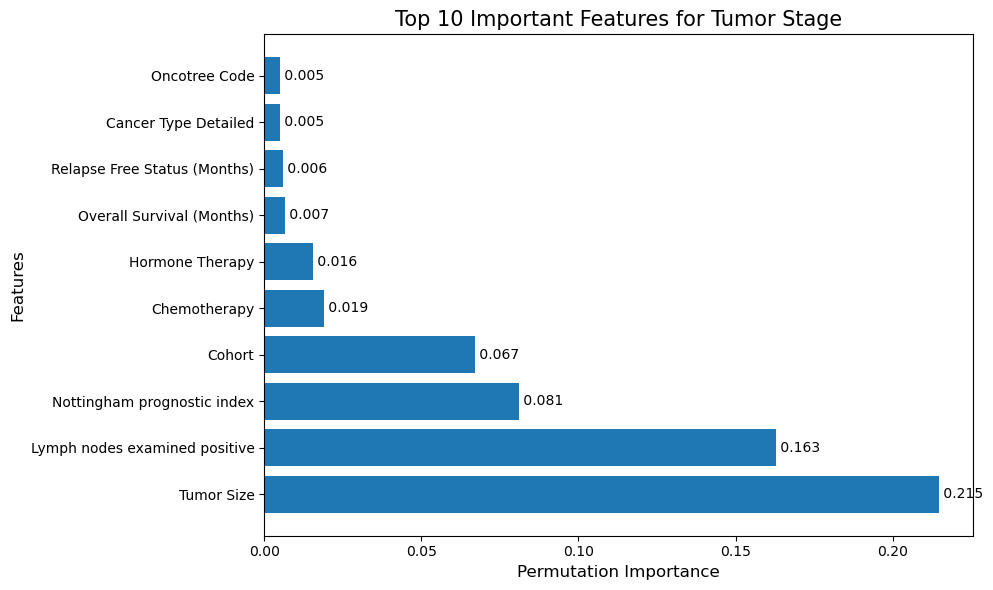

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Features for Tumor Stage", fontsize=15)

top_10_indices = sorted_idx_stage[:10]
top_10_importances = result_stage.importances_mean[top_10_indices]
top_10_features = [x.columns[i] for i in top_10_indices]

plt.barh(top_10_features, top_10_importances)
plt.xlabel("Permutation Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)

for i, v in enumerate(top_10_importances):
    plt.text(v, i, f' {v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Relapse

In [42]:
# Relapse
result_relapse = permutation_importance(model_relapse.best_estimator_, x_test, y_relapse_test, n_repeats=10, random_state=42)
sorted_idx_relapse = result_relapse.importances_mean.argsort()[::-1]

print("Feature importance for Relapse Free Status:")
for i in sorted_idx_relapse:
    print(f"{x.columns[i]}: {result_relapse.importances_mean[i]:.3f}")

Feature importance for Relapse Free Status:
Relapse Free Status (Months): 0.374
Patient's Vital Status: 0.236
Overall Survival (Months): 0.159
Overall Survival Status: 0.044
Nottingham prognostic index: 0.010
Lymph nodes examined positive: 0.006
Age at Diagnosis: 0.006
Neoplasm Histologic Grade: 0.006
Cohort: 0.005
Type of Breast Surgery: 0.002
Pam50 + Claudin-low subtype: 0.001
HER2 Status: 0.001
PR Status: 0.001
Number of Samples Per Patient: 0.000
Radio Therapy: 0.000
Cancer Type: 0.000
Cancer Type Detailed: 0.000
Cellularity: 0.000
ER Status: 0.000
Tumor Other Histologic Subtype: 0.000
Hormone Therapy: 0.000
Primary Tumor Laterality: 0.000
TMB (nonsynonymous): 0.000
Mutation Count: 0.000
Oncotree Code: 0.000
Sex: 0.000
Sample Type: 0.000
Integrative Cluster: 0.000
Inferred Menopausal State: -0.000
Chemotherapy: -0.001
3-Gene classifier subtype: -0.001
ER status measured by IHC: -0.002
HER2 status measured by SNP6: -0.002
Tumor Size: -0.002


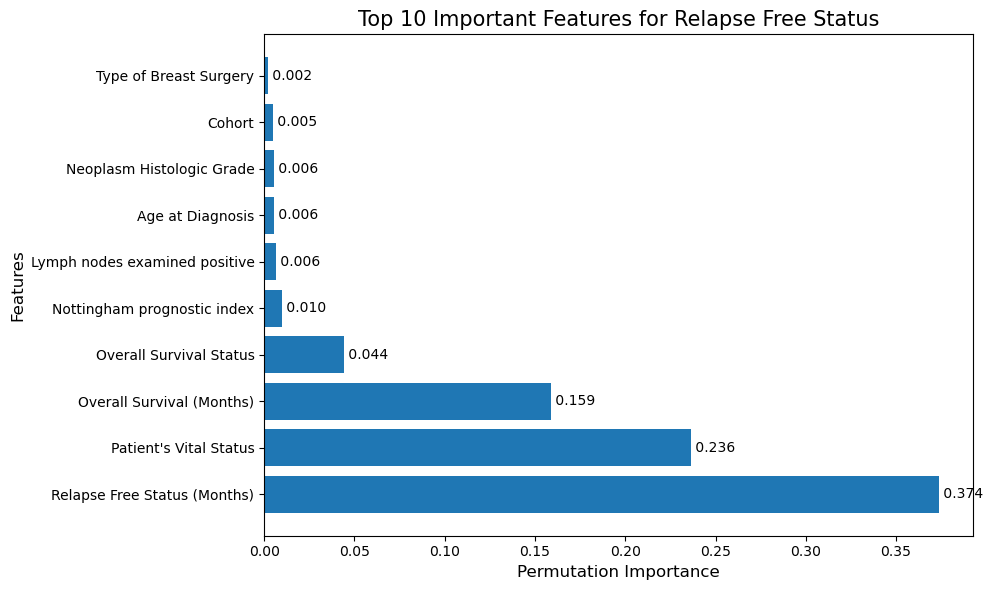

In [46]:
plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Features for Relapse Free Status", fontsize=15)

top_10_indices = sorted_idx_relapse[:10]
top_10_importances = result_relapse.importances_mean[top_10_indices]
top_10_features = [x.columns[i] for i in top_10_indices]

plt.barh(top_10_features, top_10_importances)
plt.xlabel("Permutation Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)

for i, v in enumerate(top_10_importances):
    plt.text(v, i, f' {v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Lazy Prediction

### Stage

In [47]:
clf_stage = LazyClassifier(verbose=2, ignore_warnings=True, custom_metric=None)
models_stage, predictions_stage = clf_stage.fit(x_train, x_test, y_stage_train, y_stage_test)
models_stage

  3%|▎         | 1/29 [00:00<00:05,  4.82it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.4661016949152542, 'Balanced Accuracy': 0.429636074270557, 'ROC AUC': None, 'F1 Score': 0.4570120200500029, 'Time taken': 0.2072279453277588}


  7%|▋         | 2/29 [00:00<00:05,  4.88it/s]

{'Model': 'BaggingClassifier', 'Accuracy': 0.864406779661017, 'Balanced Accuracy': 0.4462005305039788, 'ROC AUC': None, 'F1 Score': 0.8522024724654377, 'Time taken': 0.20241093635559082}
{'Model': 'BernoulliNB', 'Accuracy': 0.6271186440677966, 'Balanced Accuracy': 0.5848141467727676, 'ROC AUC': None, 'F1 Score': 0.6420113023296644, 'Time taken': 0.029612064361572266}


 14%|█▍        | 4/29 [00:01<00:13,  1.88it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7598870056497176, 'Balanced Accuracy': 0.350946065428824, 'ROC AUC': None, 'F1 Score': 0.733135124238306, 'Time taken': 1.4256620407104492}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.8587570621468926, 'Balanced Accuracy': 0.5145124668435013, 'ROC AUC': None, 'F1 Score': 0.8555087224527507, 'Time taken': 0.03708171844482422}
{'Model': 'DummyClassifier', 'Accuracy': 0.5508474576271186, 'Balanced Accuracy': 0.2, 'ROC AUC': None, 'F1 Score': 0.3913124015930351, 'Time taken': 0.018192052841186523}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.6242937853107344, 'Balanced Accuracy': 0.3835006189213086, 'ROC AUC': None, 'F1 Score': 0.6255456247542657, 'Time taken': 0.020613908767700195}


 41%|████▏     | 12/29 [00:02<00:02,  6.61it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.748587570621469, 'Balanced Accuracy': 0.3604357206012378, 'ROC AUC': None, 'F1 Score': 0.729264670333314, 'Time taken': 0.2523000240325928}
{'Model': 'GaussianNB', 'Accuracy': 0.09887005649717515, 'Balanced Accuracy': 0.25647957559681694, 'ROC AUC': None, 'F1 Score': 0.05875735440239122, 'Time taken': 0.022988080978393555}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6610169491525424, 'Balanced Accuracy': 0.31715366931918654, 'ROC AUC': None, 'F1 Score': 0.6422273461095376, 'Time taken': 0.028603792190551758}
{'Model': 'LabelPropagation', 'Accuracy': 0.6384180790960452, 'Balanced Accuracy': 0.3347296198054819, 'ROC AUC': None, 'F1 Score': 0.6305025847447939, 'Time taken': 0.09514904022216797}


 48%|████▊     | 14/29 [00:02<00:02,  7.18it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.6384180790960452, 'Balanced Accuracy': 0.3347296198054819, 'ROC AUC': None, 'F1 Score': 0.6305025847447939, 'Time taken': 0.13327288627624512}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7203389830508474, 'Balanced Accuracy': 0.4410270557029177, 'ROC AUC': None, 'F1 Score': 0.7255796640287795, 'Time taken': 0.07648897171020508}


 55%|█████▌    | 16/29 [00:03<00:02,  5.64it/s]

{'Model': 'LinearSVC', 'Accuracy': 0.7570621468926554, 'Balanced Accuracy': 0.36223660477453584, 'ROC AUC': None, 'F1 Score': 0.7381705749720519, 'Time taken': 0.42084193229675293}
{'Model': 'LogisticRegression', 'Accuracy': 0.7909604519774012, 'Balanced Accuracy': 0.4553732979664014, 'ROC AUC': None, 'F1 Score': 0.7793390418750975, 'Time taken': 0.13613319396972656}
{'Model': 'NearestCentroid', 'Accuracy': 0.5451977401129944, 'Balanced Accuracy': 0.5346277630415561, 'ROC AUC': None, 'F1 Score': 0.5700025241509655, 'Time taken': 0.04324197769165039}


 72%|███████▏  | 21/29 [00:03<00:00,  9.22it/s]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.711864406779661, 'Balanced Accuracy': 0.4122963748894783, 'ROC AUC': None, 'F1 Score': 0.6996524155109908, 'Time taken': 0.06579995155334473}
{'Model': 'Perceptron', 'Accuracy': 0.7231638418079096, 'Balanced Accuracy': 0.430310875331565, 'ROC AUC': None, 'F1 Score': 0.7176150153546614, 'Time taken': 0.04747295379638672}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.14124293785310735, 'Balanced Accuracy': 0.21968806366047744, 'ROC AUC': None, 'F1 Score': 0.12034906385810491, 'Time taken': 0.06102395057678223}


 86%|████████▌ | 25/29 [00:03<00:00,  9.21it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.844632768361582, 'Balanced Accuracy': 0.40392290008841736, 'ROC AUC': None, 'F1 Score': 0.8211031601267667, 'Time taken': 0.2866067886352539}
{'Model': 'RidgeClassifier', 'Accuracy': 0.7203389830508474, 'Balanced Accuracy': 0.3284187444739169, 'ROC AUC': None, 'F1 Score': 0.6932939505100771, 'Time taken': 0.022017955780029297}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7259887005649718, 'Balanced Accuracy': 0.32989566755083993, 'ROC AUC': None, 'F1 Score': 0.6985163575808088, 'Time taken': 0.04782390594482422}
{'Model': 'SGDClassifier', 'Accuracy': 0.7824858757062146, 'Balanced Accuracy': 0.5004519893899204, 'ROC AUC': None, 'F1 Score': 0.7658391543059322, 'Time taken': 0.10327911376953125}


 93%|█████████▎| 27/29 [00:04<00:00,  8.74it/s]

{'Model': 'SVC', 'Accuracy': 0.7909604519774012, 'Balanced Accuracy': 0.377416091954023, 'ROC AUC': None, 'F1 Score': 0.7676635843385594, 'Time taken': 0.25539088249206543}
{'Model': 'XGBClassifier', 'Accuracy': 0.8728813559322034, 'Balanced Accuracy': 0.5319568523430592, 'ROC AUC': None, 'F1 Score': 0.8660473464384516, 'Time taken': 0.34076499938964844}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 1413, number of used features: 90
[LightGBM] [Info] Start training from score -4.950885
[LightGBM] [Info] Start training from score -1.040864
[LightGBM] [Info] Start training from score -0.592895
[LightGBM] [Info] Start training from score -2.517272
[LightGBM] [Info] Start training from score -5.056246
[LightGBM] [Warning] 

100%|██████████| 29/29 [00:05<00:00,  5.69it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
{'Model': 'LGBMClassifier', 'Accuracy': 0.864406779661017, 'Balanced Accuracy': 0.45092272325375776, 'ROC AUC': None, 'F1 Score': 0.8533282224646095, 'Time taken': 0.6732878684997559}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.63,0.58,None,0.64,0.03
NearestCentroid,0.55,0.53,None,0.57,0.04
XGBClassifier,0.87,0.53,None,0.87,0.34
DecisionTreeClassifier,0.86,0.51,None,0.86,0.04
SGDClassifier,0.78,0.50,None,0.77,0.10
LogisticRegression,0.79,0.46,None,0.78,0.14
LGBMClassifier,0.86,0.45,None,0.85,0.67
BaggingClassifier,0.86,0.45,None,0.85,0.20
LinearDiscriminantAnalysis,0.72,0.44,None,0.73,0.08


### Relapse

In [48]:
clf_relapse = LazyClassifier(verbose=2, ignore_warnings=True, custom_metric=None)
models_relapse, predictions_relapse = clf_relapse.fit(x_train, x_test, y_relapse_train, y_relapse_test)
models_relapse

 10%|█         | 3/29 [00:00<00:02,  8.70it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.9350282485875706, 'Balanced Accuracy': 0.925631805014484, 'ROC AUC': 0.925631805014484, 'F1 Score': 0.9345273559782877, 'Time taken': 0.2714710235595703}
{'Model': 'BaggingClassifier', 'Accuracy': 0.9350282485875706, 'Balanced Accuracy': 0.9316252122665069, 'ROC AUC': 0.9316252122665067, 'F1 Score': 0.9349887198231785, 'Time taken': 0.09798789024353027}
{'Model': 'BernoulliNB', 'Accuracy': 0.864406779661017, 'Balanced Accuracy': 0.8477674557986214, 'ROC AUC': 0.8477674557986216, 'F1 Score': 0.8625327947361844, 'Time taken': 0.021924972534179688}


 28%|██▊       | 8/29 [00:00<00:02, 10.12it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.940677966101695, 'Balanced Accuracy': 0.9327240035960443, 'ROC AUC': 0.9327240035960443, 'F1 Score': 0.9403138065908375, 'Time taken': 0.40660977363586426}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9209039548022598, 'Balanced Accuracy': 0.9174907601638198, 'ROC AUC': 0.9174907601638198, 'F1 Score': 0.9209039548022598, 'Time taken': 0.05424213409423828}
{'Model': 'DummyClassifier', 'Accuracy': 0.6016949152542372, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.45206707918572325, 'Time taken': 0.02788710594177246}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.8192090395480226, 'Balanced Accuracy': 0.807811407451803, 'ROC AUC': 0.8078114074518031, 'F1 Score': 0.8184994131935915, 'Time taken': 0.026285886764526367}


 41%|████▏     | 12/29 [00:01<00:01, 10.65it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.8898305084745762, 'Balanced Accuracy': 0.8712915792628109, 'ROC AUC': 0.8712915792628109, 'F1 Score': 0.8877605259395301, 'Time taken': 0.24076008796691895}
{'Model': 'GaussianNB', 'Accuracy': 0.4322033898305085, 'Balanced Accuracy': 0.5269703326341025, 'ROC AUC': 0.5269703326341024, 'F1 Score': 0.30077818601674344, 'Time taken': 0.021750926971435547}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.8700564971751412, 'Balanced Accuracy': 0.8572570172809909, 'ROC AUC': 0.8572570172809908, 'F1 Score': 0.8689489117629355, 'Time taken': 0.03109884262084961}
{'Model': 'LabelPropagation', 'Accuracy': 0.7994350282485876, 'Balanced Accuracy': 0.7853860753171511, 'ROC AUC': 0.7853860753171511, 'F1 Score': 0.7982038222833079, 'Time taken': 0.08965301513671875}


 48%|████▊     | 14/29 [00:01<00:01, 11.41it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.7994350282485876, 'Balanced Accuracy': 0.7853860753171511, 'ROC AUC': 0.7853860753171511, 'F1 Score': 0.7982038222833079, 'Time taken': 0.09850597381591797}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.923728813559322, 'Balanced Accuracy': 0.912646089301768, 'ROC AUC': 0.9126460893017679, 'F1 Score': 0.9230151295273724, 'Time taken': 0.04857206344604492}
{'Model': 'LinearSVC', 'Accuracy': 0.9378531073446328, 'Balanced Accuracy': 0.9303765857556687, 'ROC AUC': 0.9303765857556687, 'F1 Score': 0.9375186358580417, 'Time taken': 0.12235498428344727}


 55%|█████▌    | 16/29 [00:01<00:01, 11.24it/s]

{'Model': 'LogisticRegression', 'Accuracy': 0.9350282485875706, 'Balanced Accuracy': 0.925631805014484, 'ROC AUC': 0.925631805014484, 'F1 Score': 0.9345273559782877, 'Time taken': 0.06037497520446777}
{'Model': 'NearestCentroid', 'Accuracy': 0.8107344632768362, 'Balanced Accuracy': 0.8067625611826991, 'ROC AUC': 0.806762561182699, 'F1 Score': 0.8114456294180774, 'Time taken': 0.04030799865722656}


 72%|███████▏  | 21/29 [00:02<00:00, 12.68it/s]

{'Model': 'NuSVC', 'Accuracy': 0.9180790960451978, 'Balanced Accuracy': 0.9031565278193987, 'ROC AUC': 0.9031565278193987, 'F1 Score': 0.9168688491708624, 'Time taken': 0.2538130283355713}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.9209039548022598, 'Balanced Accuracy': 0.9019079013085606, 'ROC AUC': 0.9019079013085606, 'F1 Score': 0.9191622450127492, 'Time taken': 0.025882244110107422}
{'Model': 'Perceptron', 'Accuracy': 0.8813559322033898, 'Balanced Accuracy': 0.8702427329937069, 'ROC AUC': 0.8702427329937069, 'F1 Score': 0.880535572182535, 'Time taken': 0.03186202049255371}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.7768361581920904, 'Balanced Accuracy': 0.7977724503046648, 'ROC AUC': 0.797772450304665, 'F1 Score': 0.7787501399704789, 'Time taken': 0.05024290084838867}


 79%|███████▉  | 23/29 [00:02<00:00,  9.80it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9124293785310734, 'Balanced Accuracy': 0.8960643292378383, 'ROC AUC': 0.8960643292378384, 'F1 Score': 0.9109634505160493, 'Time taken': 0.296004056930542}
{'Model': 'RidgeClassifier', 'Accuracy': 0.923728813559322, 'Balanced Accuracy': 0.912646089301768, 'ROC AUC': 0.9126460893017679, 'F1 Score': 0.9230151295273724, 'Time taken': 0.02864813804626465}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9265536723163842, 'Balanced Accuracy': 0.9149935071421437, 'ROC AUC': 0.9149935071421437, 'F1 Score': 0.9258037623898996, 'Time taken': 0.047924041748046875}
{'Model': 'SGDClassifier', 'Accuracy': 0.9350282485875706, 'Balanced Accuracy': 0.9340225751673159, 'ROC AUC': 0.934022575167316, 'F1 Score': 0.9351398088923474, 'Time taken': 0.040899038314819336}


 97%|█████████▋| 28/29 [00:02<00:00, 10.47it/s]

{'Model': 'SVC', 'Accuracy': 0.940677966101695, 'Balanced Accuracy': 0.9327240035960443, 'ROC AUC': 0.9327240035960443, 'F1 Score': 0.9403138065908375, 'Time taken': 0.26563310623168945}
{'Model': 'XGBClassifier', 'Accuracy': 0.9491525423728814, 'Balanced Accuracy': 0.9433623014683847, 'ROC AUC': 0.9433623014683847, 'F1 Score': 0.9489529599606977, 'Time taken': 0.11897683143615723}
[LightGBM] [Info] Number of positive: 587, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 1413, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.415428 -> initscore=-0.341570
[LightGBM] [Info] Start training from score -0.341570
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:03<00:00,  9.10it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9491525423728814, 'Balanced Accuracy': 0.9433623014683847, 'ROC AUC': 0.9433623014683847, 'F1 Score': 0.9489529599606977, 'Time taken': 0.3296971321105957}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.95,0.94,0.94,0.95,0.33
XGBClassifier,0.95,0.94,0.94,0.95,0.12
SGDClassifier,0.94,0.93,0.93,0.94,0.04
CalibratedClassifierCV,0.94,0.93,0.93,0.94,0.41
SVC,0.94,0.93,0.93,0.94,0.27
BaggingClassifier,0.94,0.93,0.93,0.93,0.10
LinearSVC,0.94,0.93,0.93,0.94,0.12
AdaBoostClassifier,0.94,0.93,0.93,0.93,0.27
LogisticRegression,0.94,0.93,0.93,0.93,0.06
